In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("OK — Librerías cargadas correctamente")

OK — Librerías cargadas correctamente


# Reto 1: Relación entre los datos de entrada

In [10]:
df_atletas = pd.read_csv("data/atletas.csv")    # Cambia por el nombre real
df_medallas = pd.read_csv("data/medallas.csv")  # Idem

print(df_atletas.head())
print(df_medallas.head())

   ID                      Name Sex   Age  Height  Weight            Team  NOC
0   1                 A Dijiang   M  24.0   180.0    80.0           China  CHN
1   2                  A Lamusi   M  23.0   170.0    60.0           China  CHN
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN         Denmark  DEN
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden  DEN
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands  NED
   ID        Games  Year  Season       City          Sport  \
0   1  1992 Summer  1992  Summer  Barcelona     Basketball   
1   2  2012 Summer  2012  Summer     London           Judo   
2   3  1920 Summer  1920  Summer  Antwerpen       Football   
3   4  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4   5  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              Event Medal  
0       Basketball Men's Basketball   NaN  
1      Judo Men's Extra-Lightweight   NaN  
2           Football 

### Explicación de que aporta cada tabla y cómo se relacionan
La primera tabla (atletas.csv) recoge información personal y básica de cada deportista: un ID único, nombre, sexo, edad, altura, peso, país/equipo y el NOC (comité olímpico nacional).  
La segunda tabla (medallas.csv) describe cada participación olímpica: enlaza el mismo ID de atleta con la edición de los Juegos (año, ciudad, verano/invierno), el deporte, el evento concreto y el tipo de medalla, si la obtuvo.  
Ambas se relacionan a través de la columna ID: gracias a ella podemos unir los datos personales del atleta con sus resultados deportivos en cada edición de los Juegos.

### Muestra un listado de ejemplo (5–10 filas) con: nombre del atleta, país, tipo de juegos, años en los que participó y medallas obtenidas en cada año

In [11]:
df_JJOO = pd.merge(df_atletas, df_medallas, on='ID', how='inner')

# Limpiar datos: filtrar solo filas donde se obtuvo medalla (Medal no es NaN)
df_JJOO_medallas = df_JJOO[df_JJOO['Medal'].notna()]

resumen = (
    df_JJOO_medallas
    .groupby(['Name', 'Team', 'Season', 'Year'])
    .agg(
        Medallas_Obtenidas = ('Medal', 'count')  # Cuenta el número de medallas por grupo
    )
    .reset_index()
)
print(resumen.head(10))

# Mostrar los primeros 5 registros que tengan más de 1 medalla obtenida
print(resumen[resumen['Medallas_Obtenidas'] > 1].head(5))

                    Name                                            Team  \
0              A. Albert  Union des Socits Franais de Sports Athletiques   
1              A. Dubois                                       Gitana-21   
2  A. Joshua "Josh" West                                   Great Britain   
3               A. Lawry                                        Cornwall   
4            A. M. Woods          St. Louis Amateur Athletic Association   
5            A. R. Upton           Brussels Swimming and Water Polo Club   
6           A. Willcocks                                        Cornwall   
7             Aage Birch                                           Snude   
8      Aage Ernst Larsen                                         Denmark   
9       Aage Hy Pedersen                                         Denmark   

   Season  Year  Medallas_Obtenidas  
0  Summer  1900                   1  
1  Summer  1900                   2  
2  Summer  2008                   1  
3  Summer  

# RETO 2


In [12]:
df_JJOO['Age'] = pd.to_numeric(df_JJOO['Age'], errors='coerce')

df_edades = df_JJOO.dropna(subset=['Age'])

tabla_edades = (
    df_edades
    .groupby(['Season', 'Sex'])['Age']
    .agg(['mean', 'count'])  # media y nº de registros
    .reset_index()
)

tabla_pivot = tabla_edades.pivot(index='Sex', columns='Season', values='mean')
print("\nEdad media (tabla pivot):")
print(tabla_pivot)


Edad media (tabla pivot):
Season     Summer     Winter
Sex                         
F       21.899688  21.694002
M       24.671116  23.315536


Los datos muestran que la edad media de los atletas en los Juegos de Invierno es inferior a la de los Juegos de Verano. Aunque la diferencia no es muy grande, sí es consistente: los participantes en competiciones invernales tienden a ser ligeramente más jóvenes. Este resultado indica simplemente un patrón general en la distribución de edades entre ambas temporadas, sin que pueda atribuirse a una causa concreta con la información disponible actualmente. 

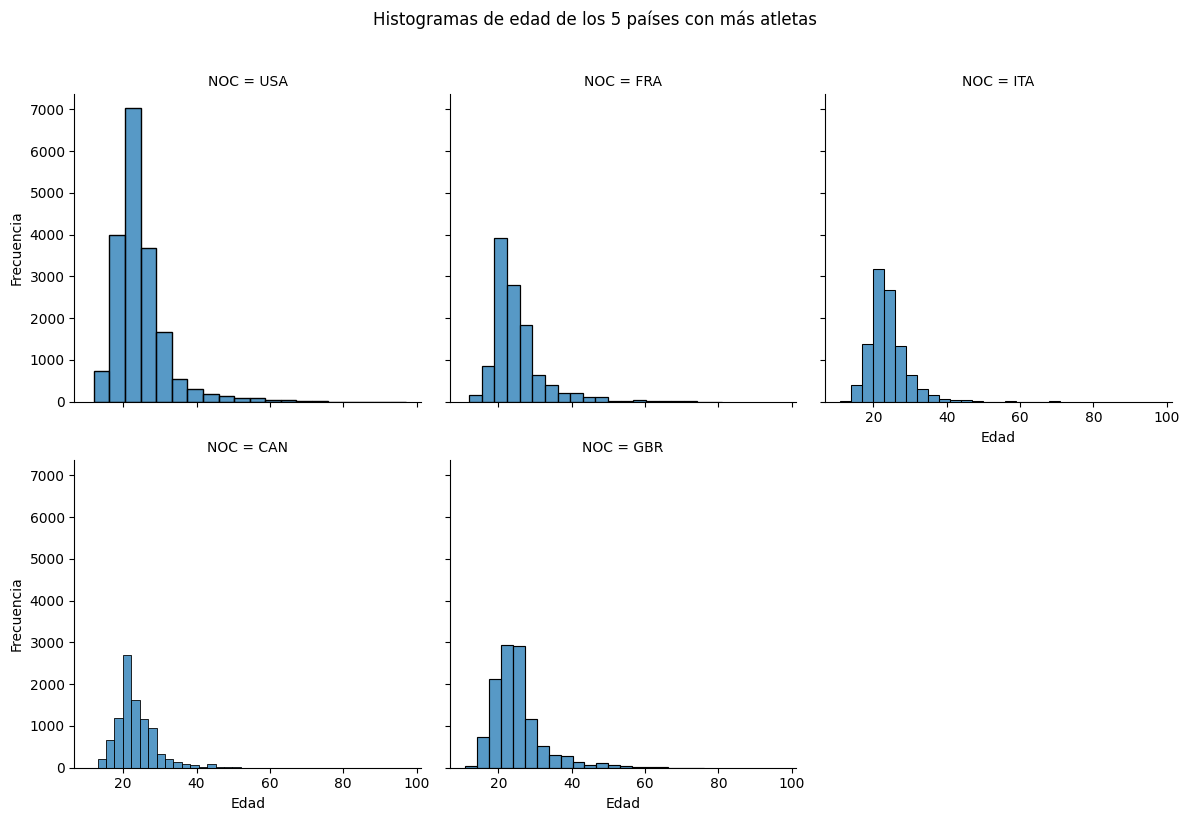

In [13]:
# 1) Top 5 países con más atletas (atletas únicos)
top5_paises = (
    df_JJOO.dropna(subset=['Age'])           # sólo registros con edad
           .groupby('NOC')['ID']
           .nunique()                        # nº de atletas distintos
           .nlargest(5)
           .index
)

# 2) Datos solo de esos países y con edad válida
df_top5 = df_JJOO[df_JJOO['NOC'].isin(top5_paises) & df_JJOO['Age'].notna()]

# 3) FacetGrid de histogramas de edad por país
g = sns.FacetGrid(df_top5, col='NOC', col_wrap=3, height=4, sharex=True, sharey=True)
g.map_dataframe(sns.histplot, x='Age', bins=20)

g.set_axis_labels("Edad", "Frecuencia")
g.fig.suptitle("Histogramas de edad de los 5 países con más atletas", y=1.02)
plt.tight_layout()
plt.show()


   Season Sex  Conteo  Porcentaje
0  Summer   F   59443   26.709713
1  Summer   M  163109   73.290287
2  Winter   F   15079   31.049749
3  Winter   M   33485   68.950251


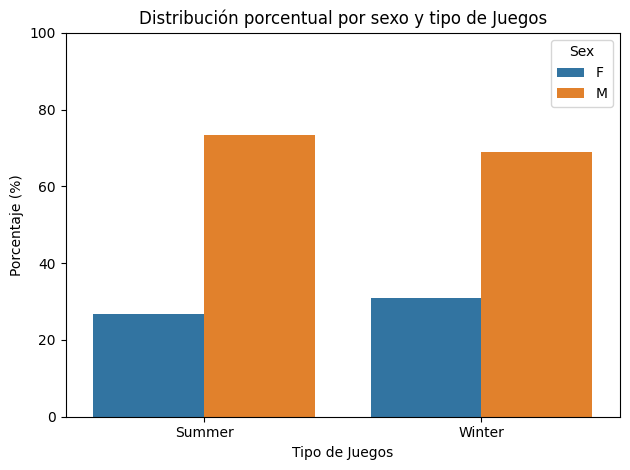

In [14]:
# Nos quedamos solo con filas que tienen Season y Sex
df_sexo = df_JJOO.dropna(subset=['Season', 'Sex'])

# Conteos por temporada y sexo
tabla_sexo = (
    df_sexo
    .groupby(['Season', 'Sex'])['ID']   # puedes usar 'ID' o simplemente .size()
    .count()
    .reset_index(name='Conteo')
)

# Pasamos a porcentajes dentro de cada temporada (Summer / Winter)
tabla_sexo['Porcentaje'] = (
    tabla_sexo['Conteo'] /
    tabla_sexo.groupby('Season')['Conteo'].transform('sum')
) * 100

print(tabla_sexo)

# Gráfica: barras agrupadas con porcentajes
sns.barplot(
    data=tabla_sexo,
    x='Season',
    y='Porcentaje',
    hue='Sex'
)

plt.title('Distribución porcentual por sexo y tipo de Juegos')
plt.xlabel('Tipo de Juegos')
plt.ylabel('Porcentaje (%)')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


Se ha utilizado un gráfico de barras agrupadas con el porcentaje de participaciones en el eje vertical, diferenciando el tipo de Juegos (Verano/Invierno) en el eje horizontal y el sexo mediante el color. Este tipo de gráfica permite comparar de forma muy directa la proporción de hombres y mujeres dentro de cada edición, manteniendo siempre la referencia común del 100% por temporada. Frente a mostrar conteos absolutos, el uso de porcentajes facilita la comparación relativa entre Verano e Invierno independientemente del número total de participaciones en cada uno.